In [1]:
import cooler
import numpy as np
import pandas as pd
import glob, os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats 
from itertools import product

import matplotlib.gridspec as gridspec


def get_checker(shape,set_of_xy,alpha,the_cmap='Blues'):
    """
    describe it

    Parameters
    ----------
    shape : tuple
        A tuple describing the shape of the output checkerboard mask
    set_of_xy : array_of_tuples
        Where in each tuple we would have a pair of index lists to
        be intersected.
    alpha : scalar
        transparency for the areas corresponding to intersected indices
        or in other words in the area we want to highlight
    the_cmap : string
        name of the matplotlib cmap to be used for highlighting desired
        areas of the heatmap

    Returns
    -------
    checker : image
        A proper RGB image with alphas channel set such that the
        highlighted areas are alpha-transparent, and non-highlighted
        ones are fully transparent.

    """
    # add some check here ...
    # ...
    # THIS IS HOW WE MAKE A CHECKERBOARD MASK ON TOP OF HEATMAP-SLICE:
    checker = np.zeros(shape)
    # combine all of the areas we'd like ot highlight
    for x,y in set_of_xy:
        xv,yv = np.meshgrid(x,y)
        checker[xv,yv] += 1
    # define transparency, by clipping non-zero values,
    # i.e. the ones that we'd like to highlight to the desired
    # alpha level
    alphas = np.clip(checker,0,alpha)
    # cmap of choice ...
    cmap = plt.cm.get_cmap(the_cmap)
    # checker is already normalized between 0 and 1
    # so, just turn into RGB:
    checker = cmap(checker)
    # blend in an alpha chanel:
    checker[...,-1] = alphas
    return checker



In [6]:
cool_file='U54-HFFc6-DSG-DdeI-20180319-R1-T1__hg38.hg38.mapq_30.1000.mcool'
comp_file=pd.read_csv('U54-HFFc6-DSG-DdeI-20180319-R1-T1.cis.250000.vecs.tsv',sep="\t")
c = cooler.Cooler(cool_file+'::/resolutions/250000')

# a chromosome pair we'll be working with ...
chr_split = c.matrix(balance=True).fetch("chr13","chr19")

# TAKE good chroms ...
chroms = c.chromnames[:-3]

In [25]:
mat = {}
mat['AA'] = np.zeros((len(chroms),len(chroms)))
mat['BB'] = np.zeros((len(chroms),len(chroms)))
mat['AB'] = np.zeros((len(chroms),len(chroms)))
mat['tot'] = np.zeros((len(chroms),len(chroms)))

# np.nanmean(c.matrix(balance=True).fetch("chr13","chr19"))
for i in range(len(chroms)):
    for j in range(len(chroms)):
        if i > j:
            chri, chrj = chroms[i], chroms[j]
            # split into aa,bb,ba
            
            ev_chri=comp_file[comp_file["chrom"]==chri].copy()
            ev_chrj=comp_file[comp_file["chrom"]==chrj].copy()

            ev_chri.reset_index(inplace=True)
            ev_chrj.reset_index(inplace=True)

            # chri eigenvector into A and B
            chri_A=ev_chri[ev_chri['E1']>0].index
            chri_B=ev_chri[ev_chri['E1']<=0].index
            # chrj eigenvector into A and B
            chrj_A=ev_chrj[ev_chrj['E1']>0].index
            chrj_B=ev_chrj[ev_chrj['E1']<=0].index
            
            #
            chr_split = c.matrix(balance=True).fetch(chri,chrj)

            AA=chr_split[chri_A, :][: ,chrj_A].flatten()
            BB=chr_split[chri_B, :][: ,chrj_B].flatten()
            AB=chr_split[chri_A, :][: ,chrj_B].flatten()
            BA=chr_split[chri_B, :][: ,chrj_A].flatten()
            
            mat['tot'][i,j] = np.nanmean(chr_split)
            mat['tot'][j,i] = mat['tot'][i,j]           

            mat['AA'][i,j] = np.nanmean(AA)
            mat['AA'][j,i] = mat['AA'][i,j]           

            mat['BB'][i,j] = np.nanmean(BB)
            mat['BB'][j,i] = mat['BB'][i,j]           

            mat['AB'][i,j] = np.nanmean(np.concatenate((AB,BA)))
            mat['AB'][j,i] = mat['AB'][i,j]           

        elif i==j:
            mat['AA'][i,j] = np.nan
            mat['BB'][i,j] = np.nan
            mat['AB'][i,j] = np.nan
            mat['tot'][i,j] = np.nan
        else:
            pass


  
        

In [7]:
from cooltools import expected
trexp = expected.trans_expected(c, chroms)

/Users/betulakgoloksuz/Documents/miniconda3/envs/cooler-env/lib/python3.6/site-packages/cooltools/expected.py:478: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  ('chrom1', 'chrom2'))['n_total'].sum()
/Users/betulakgoloksuz/Documents/miniconda3/envs/cooler-env/lib/python3.6/site-packages/cooltools/expected.py:480: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  ('chrom1', 'chrom2'))['n_bad'].sum()


/Users/betulakgoloksuz/Documents/miniconda3/envs/cooler-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


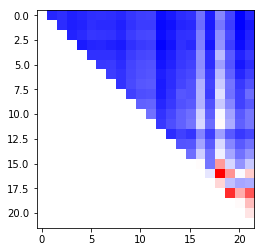

In [14]:
plt.imshow(trexp['balanced.avg'].unstack().loc[chroms,chroms],cmap="bwr")

In [23]:
weight_name = 'weight'
weight1 = weight_name+"1"
weight2 = weight_name+"2"
trexp_block = expected.blocksum_pairwise(c, chroms, transforms={'balanced': lambda p: p['count'] * p[weight1] * p[weight2]})

UnboundLocalError: local variable 'sel' referenced before assignment

In [19]:
from itertools import combinations

list(combinations(('1:0-1000','1:3000-6000',''), 2))

[('1:0-1000', '1:3000-6000'),
 ('1:0-1000', '1:9000-11000'),
 ('1:3000-6000', '1:9000-11000')]

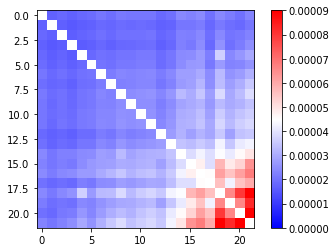

In [38]:
plt.imshow(mat["BB"],cmap="bwr",vmin=0,vmax=0.00009)
plt.colorbar()

0 0
0 0
22196 18816 17184 24304
82500
82500


/Users/betulakgoloksuz/Documents/miniconda3/envs/cooler-env/lib/python3.6/site-packages/ipykernel_launcher.py:39: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


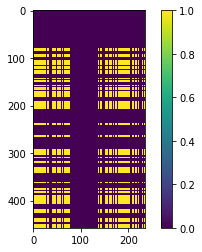

In [8]:
chr13=comp_file[comp_file["chrom"]=='chr13'].copy()
chr19=comp_file[comp_file["chrom"]=='chr19'].copy()

chr13.reset_index(inplace=True)
chr19.reset_index(inplace=True)


delta = 0.0
qhi_18 = np.nanquantile(chr13['E1'],0.5+delta)
qlo_18 = np.nanquantile(chr13['E1'],0.5-delta)
qhi_19 = np.nanquantile(chr19['E1'],0.5+delta)
qlo_19 = np.nanquantile(chr19['E1'],0.5-delta)

# redefine compartments back to above/below zero ....
# if we want to ...
qhi_18,qlo_18,qhi_19,qlo_19 = 0,0,0,0

print(qlo_18 ,qhi_18 )
# chr13 eigenvector into A and B
chr13_A=chr13[chr13['E1']>qhi_18].index
chr13_B=chr13[chr13['E1']<=qlo_18].index



print(qlo_19 ,qhi_19 )
# chr19 eigenvector into A and B
chr19_A=chr19[chr19['E1']>qhi_19].index
chr19_B=chr19[chr19['E1']<=qlo_19].index

AA=chr_split[chr13_A, :][: ,chr19_A].flatten()
BB=chr_split[chr13_B, :][: ,chr19_B].flatten()
AB=chr_split[chr13_A, :][: ,chr19_B].flatten()
BA=chr_split[chr13_B, :][: ,chr19_A].flatten()



# some tests ...
mmm = np.zeros_like(chr_split)
mmm[ np.meshgrid(chr13_A,chr19_A)] += 1
#mmm[ :, chr19_A] += 1
plt.imshow(mmm)
plt.colorbar()

print(len(AA),len(BB),len(AB),len(BA))
print(len(AA)+len(BB)+len(AB)+len(BA))
print(chr_split[~np.isnan(chr_split)].size)

/Users/betulakgoloksuz/Documents/miniconda3/envs/cooler-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
/Users/betulakgoloksuz/Documents/miniconda3/envs/cooler-env/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log
/Users/betulakgoloksuz/Documents/miniconda3/envs/cooler-env/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log


Text(0.5, 1.0, 'AB')

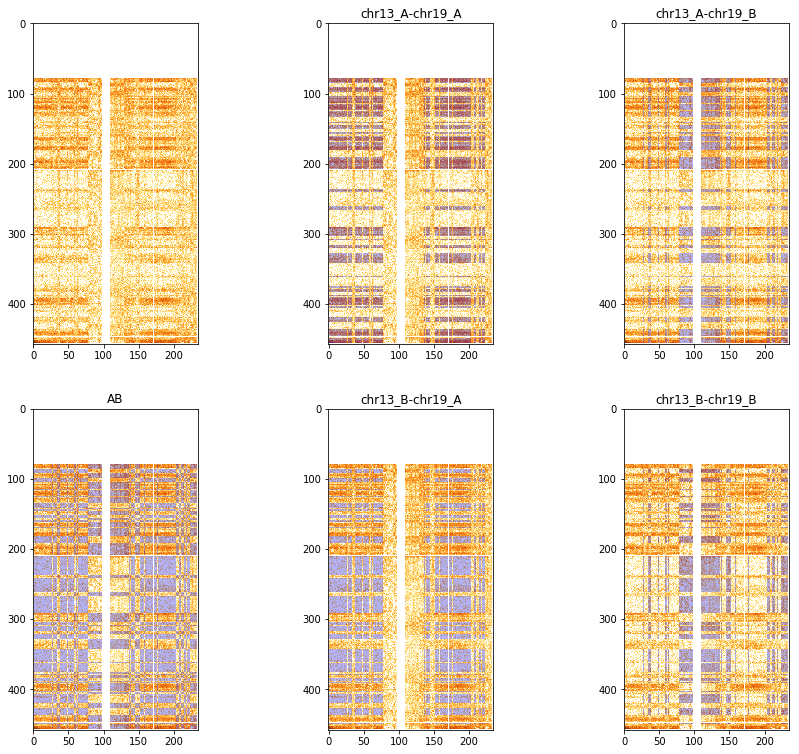

In [9]:
# constrained_layout=True
fig = plt.figure(figsize=(15,13))
gs = gridspec.GridSpec(nrows=2,ncols=3)

ab18 = [("chr13_A",chr13_A),("chr13_B",chr13_B)]
ab19 = [("chr19_A",chr19_A),("chr19_B",chr19_B)]

for i,(x,y) in enumerate(product(ab18,ab19)):
    ii = i//2
    ij = i%2
    combo = (x[1],y[1])
    ax = plt.subplot(gs[ii,ij+1])
    ax.imshow(np.log(chr_split),cmap="YlOrBr")
    #plt.imshow?
    checker = get_checker(chr_split.shape,[combo,],0.3,the_cmap='winter_r')
    ax.imshow(checker)
    #plt.colorbar()
    ax.set_title("{}-{}".format(x[0],y[0]))


# plain heatmap  
ax = plt.subplot(gs[0,0])
ax.imshow(np.log(chr_split),cmap="YlOrBr")

# complete AB ...
ax = plt.subplot(gs[1,0])
ax.imshow(np.log(chr_split),cmap="YlOrBr")
#plt.imshow?
checker = get_checker(chr_split.shape,[(chr13_A,chr19_B),(chr13_B,chr19_A)],0.3,the_cmap='winter_r')
ax.imshow(checker)
#plt.colorbar()
ax.set_title("AB")





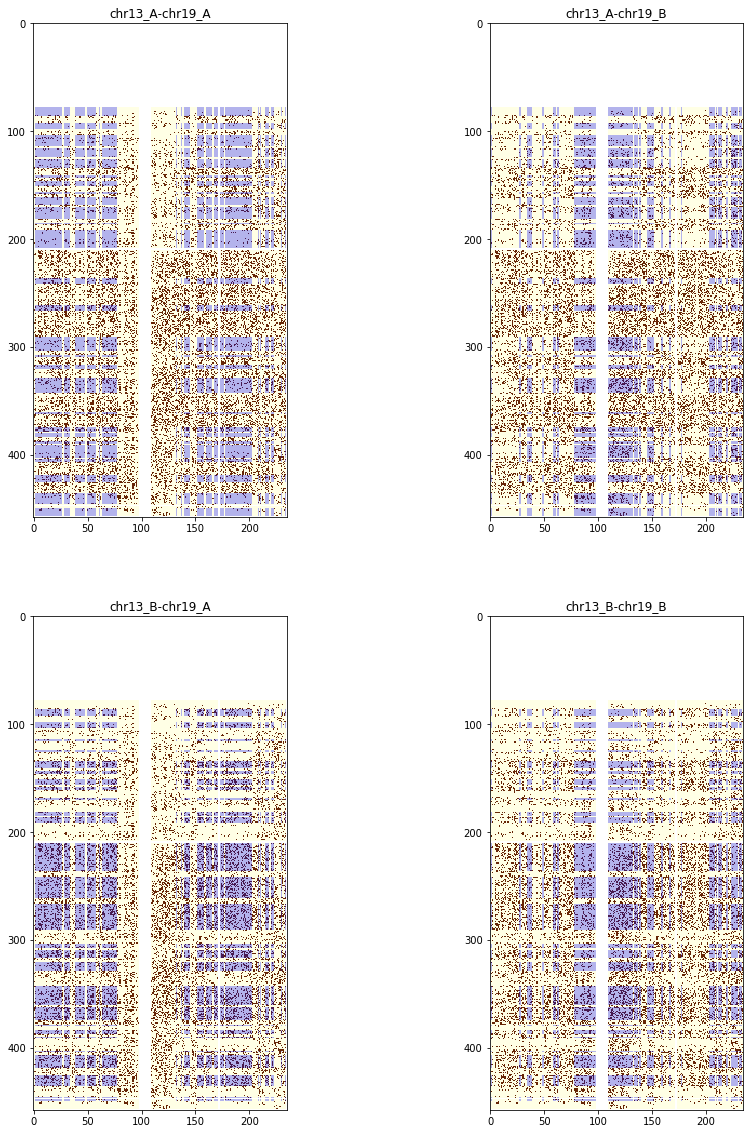

In [12]:
# constrained_layout=True
fig = plt.figure(figsize=(15,20))
gs = gridspec.GridSpec(nrows=2,ncols=2)

ab18 = [("chr13_A",chr13_A),("chr13_B",chr13_B)]
ab19 = [("chr19_A",chr19_A),("chr19_B",chr19_B)]

for i,(x,y) in enumerate(product(ab18,ab19)):
    combo = (x[1],y[1])
    ax = plt.subplot(gs[i])
    ax.imshow((chr_split_highlight),cmap="YlOrBr")
    #plt.imshow?
    checker = get_checker(chr_split.shape,[combo,],0.3,the_cmap='winter_r')
    ax.imshow(checker)
    #plt.colorbar()
    ax.set_title("{}-{}".format(x[0],y[0]))





2e-05


/Users/betulakgoloksuz/Documents/miniconda3/envs/cooler-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()
/Users/betulakgoloksuz/Documents/miniconda3/envs/cooler-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()
/Users/betulakgoloksuz/Documents/miniconda3/envs/cooler-env/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log


/Users/betulakgoloksuz/Documents/miniconda3/envs/cooler-env/lib/python3.6/site-packages/matplotlib/figure.py:2314: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  warnings.warn("Calling figure.constrained_layout, but figure not "
/Users/betulakgoloksuz/Documents/miniconda3/envs/cooler-env/lib/python3.6/site-packages/matplotlib/figure.py:2314: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  warnings.warn("Calling figure.constrained_layout, but figure not "
/Users/betulakgoloksuz/Documents/miniconda3/envs/cooler-env/lib/python3.6/site-packages/matplotlib/figure.py:2314: UserWarni

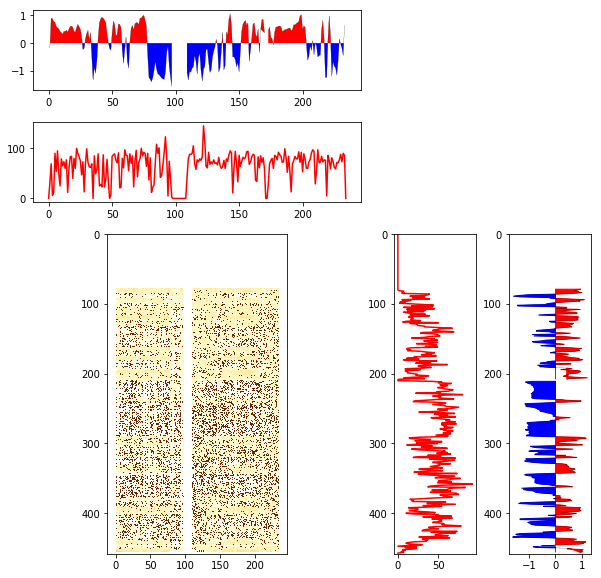

In [11]:
data=chr_split.flatten()
data = data[~np.isnan(data)]
freq_min=data[data>0].min()
# freq_max=np.quantile(data,0.999999)


chr_split_highlight = chr_split.copy()

thr = 2*(10**(-5))
print(thr)
chr_split_highlight[(chr_split>=freq_min)&(chr_split<thr)] += 1

pat_row = np.nansum(chr_split_highlight,axis=0)
pat_col = np.nansum(chr_split_highlight,axis=1)

chr19_e1 = chr19['E1']
chr13_e1 = chr13['E1']



fig = plt.figure(constrained_layout=True,figsize=(10,10))
gs = gridspec.GridSpec(nrows=3,ncols=3,
                       width_ratios=[chr19_e1.size, chr19_e1.size*0.25, chr19_e1.size*0.25],
                       height_ratios=[ chr13_e1.size*0.25,  chr13_e1.size*0.25, chr13_e1.size])

ax_hm = plt.subplot(gs[2,0])
ax_hm.imshow(np.log(chr_split_highlight),cmap="YlOrBr")


# X, Y = np.meshgrid(np.arange(chr19_e1.size), np.arange(chr13_e1.size))
# C = np.log(chr_split)
# img = ax_hm.pcolormesh(X, Y, C,cmap="YlOrBr",rasterized=True)
# ax_hm.imshow(np.log(chr_split),cmap="YlOrBr")#, aspect="auto")

#plt.colorbar()



ax = plt.subplot(gs[0,0],sharex=ax_hm)

ax.plot(chr19_e1,'k-',lw=0.2)
ax.fill_between(np.arange(chr19_e1.size), 0, chr19_e1, where=chr19_e1 >= 0,
                 facecolor='red', interpolate=True)
ax.fill_between(np.arange(chr19_e1.size), 0, chr19_e1, where=chr19_e1 < 0,
                 facecolor='blue', interpolate=True)





ax = plt.subplot(gs[1,0],sharex=ax_hm)
ax.plot(pat_row,'r-')




ax = plt.subplot(gs[2,1],sharey=ax_hm)
ax.plot(pat_col,np.arange(len(pat_col)),'r-')
ax.set_ylim(len(pat_col),0)


ax = plt.subplot(gs[2,2],sharey=ax_hm)
ax.plot(chr13_e1,np.arange(chr13_e1.size),'k-',lw=0.2)
# ax.fill_between()
ax.set_ylim(chr13_e1.size,0)
ax.fill_betweenx(np.arange(chr13_e1.size), 0, chr13_e1, where=chr13_e1>0, interpolate=True, color='red')
ax.fill_betweenx(np.arange(chr13_e1.size), 0, chr13_e1, where=chr13_e1<=0, interpolate=True, color='blue')


# that's what you do to plot x,y:
# ax.plot(x,y)
# if you give only 1 array it implies
# ax.plot(y) -> ax.plot(np.arange(len(y)),y)

#np.nansum(chr_split_highlight,axis=0)

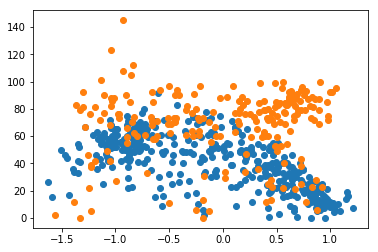

In [13]:


plt.plot(chr13_e1,pat_col,'o')
plt.plot(chr19_e1,pat_row,'o')


/Users/betulakgoloksuz/Documents/miniconda3/envs/cooler-env/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
/Users/betulakgoloksuz/Documents/miniconda3/envs/cooler-env/lib/python3.6/site-packages/ipykernel_launcher.py:40: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
/Users/betulakgoloksuz/Documents/miniconda3/envs/cooler-env/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


<Figure size 432x288 with 0 Axes>

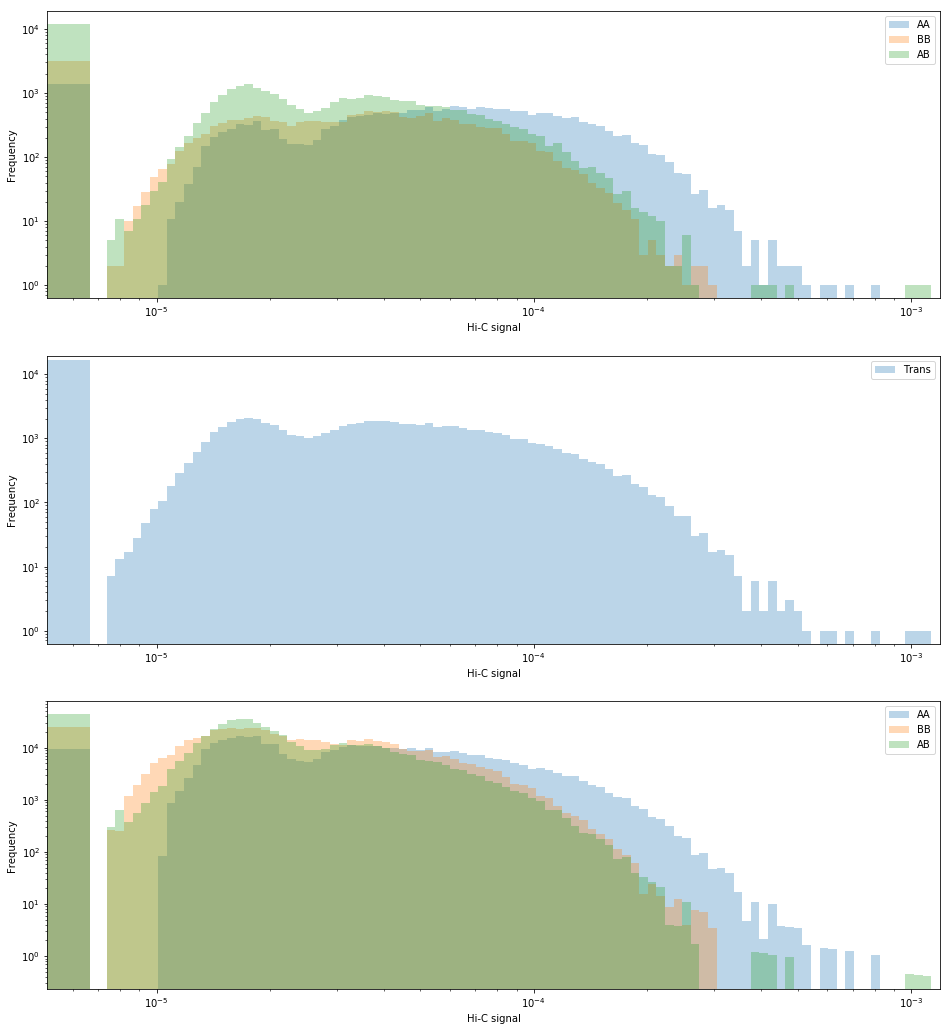

In [14]:

name=cool_file.split('_')[0]
fig = plt.figure()
AB_both=np.concatenate((AB, BA), axis=None)

data=chr_split.flatten()
data = data[~np.isnan(data)]
freq_min=data[data>0].min()
freq_max=np.quantile(data,0.999999)
bins = np.geomspace(freq_min,freq_max,100)
bins = np.concatenate(([0],bins))




fig = plt.figure(figsize=(16,18))
gs = gridspec.GridSpec(nrows=3,ncols=1)


ax = plt.subplot(gs[0])
datasets=[AA,BB,AB_both]
names_list = ['AA', 'BB','AB']
for d,name in zip(datasets,names_list):
    ax.hist(d, bins=bins,alpha=0.3,label=name,density=0)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(0,freq_max)
ax.set_xlabel('Hi-C signal')
ax.set_ylabel('Frequency')
plt.legend(fontsize=10)
ylim = ax.set_ylim()

ax = plt.subplot(gs[1])
datasets=[data,]
names_list = ['Trans',]
for d,name in zip(datasets,names_list):
    plt.hist(d, bins=bins,alpha=0.3,label=name,density=0)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(0,freq_max)
ax.set_ylim(ylim)
plt.xlabel('Hi-C signal')
plt.ylabel('Frequency')
plt.legend(fontsize=10)



# ax = plt.subplot(gs[2])
# datasets=[AA,BB]
# names_list = ['AA', 'BB','AB']
# ax.hist(datasets, bins=bins,alpha=0.3,label=name,density=0,stacked=1)
# ax.set_xscale("log")
# ax.set_yscale("log")
# ax.set_xlim(0,freq_max)
# ax.set_xlabel('Hi-C signal')
# ax.set_ylabel('Frequency')
# plt.legend(fontsize=10)
# #ax.set_ylim()


ax = plt.subplot(gs[2])
datasets=[AA,BB,AB_both]
names_list = ['AA', 'BB','AB']
for d,name in zip(datasets,names_list):
    ax.hist(d, bins=bins,alpha=0.3,label=name,density=1)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(0,freq_max)
ax.set_xlabel('Hi-C signal')
ax.set_ylabel('Frequency')
plt.legend(fontsize=10)





/Users/betulakgoloksuz/Documents/miniconda3/envs/cooler-env/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
/Users/betulakgoloksuz/Documents/miniconda3/envs/cooler-env/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
/Users/betulakgoloksuz/Documents/miniconda3/envs/cooler-env/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
/Users/betulakgoloksuz/Documents/miniconda3/envs/cooler-env/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
/Users/betulakgoloksuz/Documents/miniconda3/envs/cooler-env/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWa

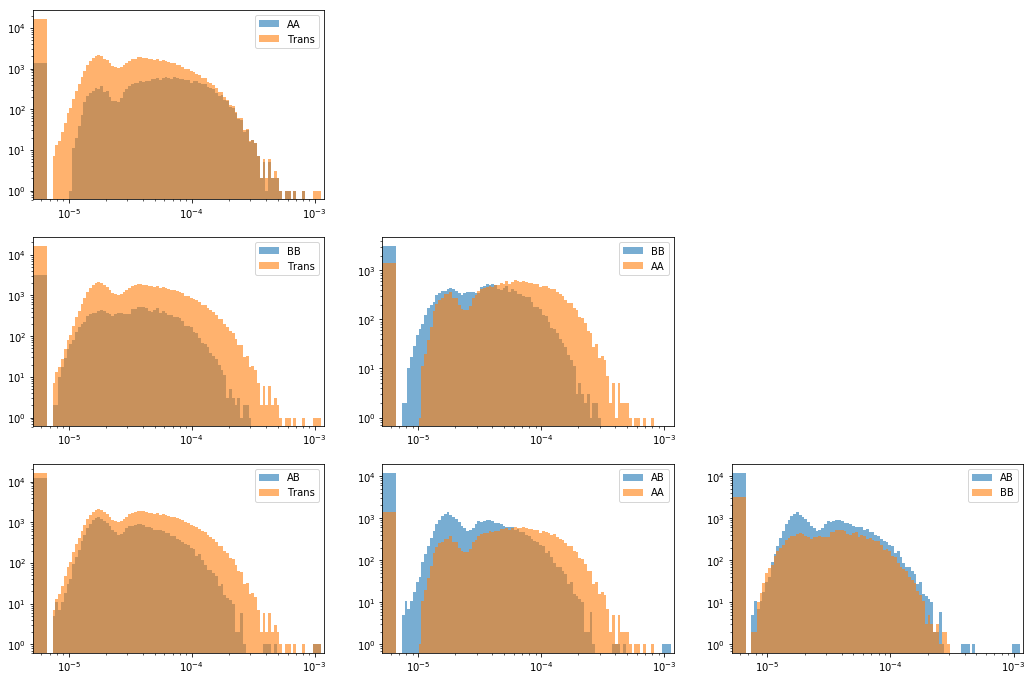

In [15]:
datasets=[data,AA,BB,AB_both]
names_list = ['Trans','AA', 'BB','AB']



fig = plt.figure(figsize=(24,16))
gs = gridspec.GridSpec(nrows=len(datasets),ncols=len(datasets))

# histogram normalized to the total number of observations
normalized = False

for i,(di,namei) in enumerate(zip(datasets,names_list)):
    for j,(dj,namej) in enumerate(zip(datasets,names_list)):
        if i>j:
            ax = plt.subplot(gs[i,j])
            ax.hist(di, bins=bins,alpha=0.6,label=namei,density=normalized)
            ax.hist(dj, bins=bins,alpha=0.6,label=namej,density=normalized)
            ax.set_xscale("log")
            ax.set_yscale("log")
            ax.set_xlim(0,freq_max)
            #ax.set_xlabel('Hi-C signal')
            #ax.set_ylabel('Frequency')
            plt.legend(fontsize=10)
#             ylim = ax.set_ylim(ylim)


   

In [99]:
plt.hist?